## Fucking imports

In [1]:
# System
import os, sys, io, glob, time
sys.path.append('..')

# Model
from models.uNet import *
from helpers.training import training
from helpers.prediction import predict
from datasets.aerial_dataset import AerialDataset
from datasets.patched_aerial_dataset import PatchedAerialDataset
from visualization.helpers import imshow_tensor, imshow_tensor_gt, generate_predictions, concatenate_images, img_crop
from preprocessing.augmentation_config import ImageAugmentationConfig
from preprocessing.rotation import *
from postprocessing.majority_voting import *
from kaggle.mask_to_submission import *
from visualization.helpers import *
import random

# ML Library
import numpy as np
import torch, torchvision
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

# Image processing
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Reloading
%load_ext autoreload
%autoreload 2

### Fucking Constants

In [2]:
TRAIN_IMAGE_DATA = '../../data/train/images/'
TRAIN_LABEL_DATA = '../../data/train/groundtruth/'
TEST_IMAGE_DATA = '../../data/test/images/'
TEST_LABEL_DATA = '../../data/test/predictions/'

SEED = 428796

BATCH_SIZE = 64
NUM_EPOCHS = 5

PATCH_SIZE = 120
OVERLAP = True
OVERLAP_AMOUNT = 60


TESTING_SIZE = 50
DATA_SIZE = 100
TRAINING_SIZE = 80

TEST_IMG_SIZE, TEST_PATCH_SIZE = 608, 16
THRESHOLD = 0.25

CUDA = True
PERM = True

LOAD = False
SAVE = False

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# if CUDA: torch.cuda.manual_seed_all(SEED)

dic = {"bsize" : BATCH_SIZE,
      "psize": PATCH_SIZE,
      "threshold" : THRESHOLD}
with open('./progress.txt', 'a') as file:
    file.writelines('\n' + "Running the code" + time.strftime("%d-%m-%Y-%h-%s") + '\n')
    file.writelines('Params : ' + str(dic))

### Fucking Indices 

In [3]:
if PERM:
    indices = np.random.permutation(np.arange(1, DATA_SIZE + 1))
    train_indices = indices[:TRAINING_SIZE]
    validation_indices = indices[TRAINING_SIZE:]
else:
    indices = np.arange(1, DATA_SIZE + 1)
    train_indices = indices[:TRAINING_SIZE]
    validation_indices = indices[TRAINING_SIZE:]

### Fucking image augmentation

In [12]:
aug_config = ImageAugmentationConfig()
aug_config.rotation(range(20, 370, 20))
aug_config.flip()
#aug_config.edge()
#aug_config.blur()
#aug_config.contrast()
# aug_config.invert()
# aug_config.convolve()

### Fucking Datasets

In [13]:
trainset = PatchedAerialDataset(TRAIN_IMAGE_DATA, TRAIN_LABEL_DATA, train_indices, PATCH_SIZE, OVERLAP, OVERLAP_AMOUNT, aug_config)
validationset = PatchedAerialDataset(TRAIN_IMAGE_DATA, TRAIN_LABEL_DATA, validation_indices, PATCH_SIZE, OVERLAP, OVERLAP_AMOUNT, aug_config)

Loading 80 aerial images...done
Loading 80 aerial images...done
Loading 20 aerial images...done
Loading 20 aerial images...done


### Fucking Data Iterators

In [14]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validationloader = DataLoader(validationset, batch_size=1, shuffle=False)

/home/ballet/anaconda3/envs/MLEnv/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


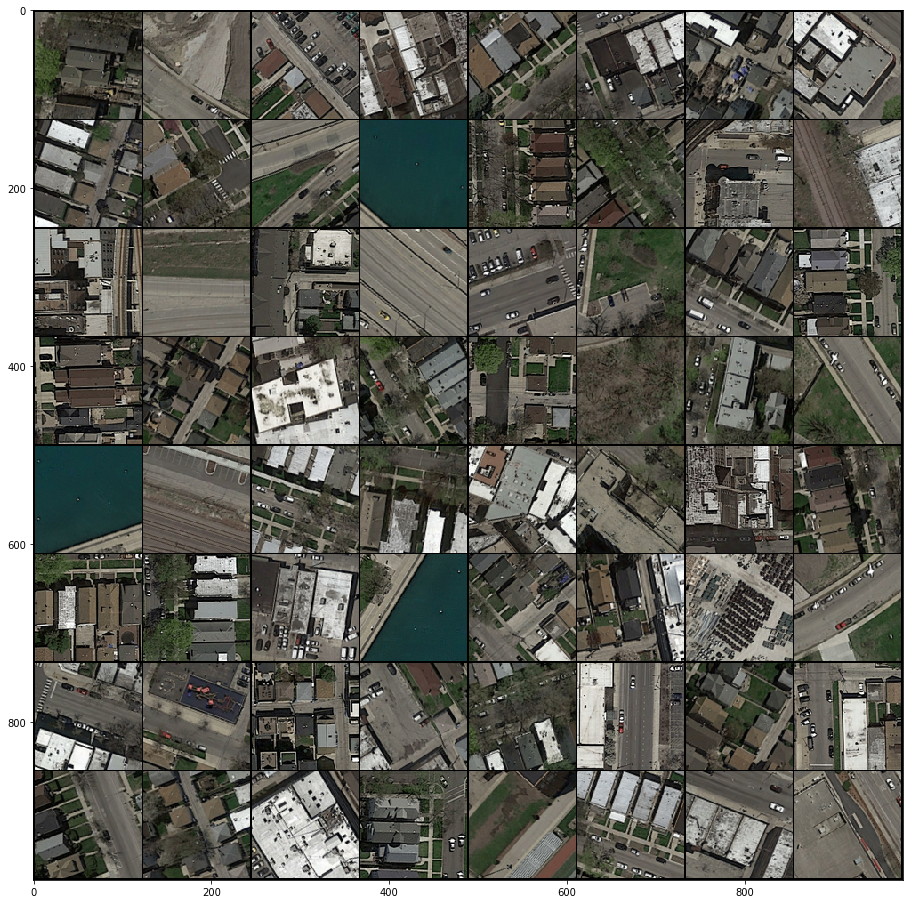

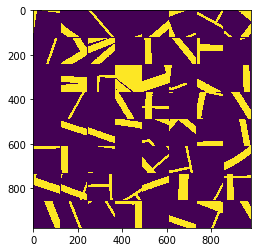

In [15]:
images, labels = iter(trainloader).next()

# show images
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(images, normalize=True))
imshow_tensor_gt(torchvision.utils.make_grid(labels))

### Fucking uNet

In [ ]:
channel_sizes = {
    'CHANNELS_L0': 3,
    'CHANNELS_L1': 16,
    'CHANNELS_L2': 32,
    'CHANNELS_L3': 64,
    'CHANNELS_L4': 128
}

nbr_layers = 3
model = UNet(nbr_layers, channel_sizes).cuda()

### Fucking Training params

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

### Fucking Training

In [ ]:
datasets = {'train':trainset, 'val':validationset}
dataloaders = {'train':trainloader, 'val':validationloader}

if LOAD and not SAVE:
    m = 'mytraining_12-12-2017-Dec-1513108664.pt'
    model.load_state_dict(torch.load('./checkpoints/' + m).state_dict())
else:
    scores, train_loss, val_loss, best_model = training(NUM_EPOCHS, model, criterion, optimizer, lr_scheduler, datasets, dataloaders, PATCH_SIZE, cuda=CUDA)

In [ ]:
if SAVE:
    torch.save(model, './checkpoints/mytraining_'+ time.strftime("%d-%m-%Y-%h-%s") +'.pt')

### Fucking plotting the fucking accuracy vs epoch fucking plot

In [ ]:
# Print accuracy curve
if not LOAD:
    fig = plt.figure()
    x = np.arange(0, NUM_EPOCHS)
    plt.plot(x, scores, '--')
    fig.suptitle(time.strftime("%d-%m-%Y" ))

    plt.xlabel('epoch')
    plt.ylabel('accuracy (validation data)')
    plt.savefig('../../plots/epoch_accuracy' + time.strftime("%d-%m-%Y-%h-%s") + '.png', dpi=fig.dpi)
    plt.show()

### Time to get the FUCKING testing data

In [ ]:
test_indices = np.arange(1, TESTING_SIZE+ 1,1)

#Attention ici
MAJORITY_VOTING = False

testset = AerialDataset(TEST_IMAGE_DATA, test_indices, aug_config, majority_voting=MAJORITY_VOTING)
testloader = DataLoader(testset, batch_size=1, shuffle=False)


### Feed the motherfucking NN testing data

In [ ]:
predicted_labels = predict(model, testloader, CUDA)

### How about looking at one output ?

In [ ]:
image_id = 0
plt.imshow(predicted_labels[image_id])

In [ ]:
if MAJORITY_VOTING:
    predicted_labels_majority = majority_voting(predicted_labels, TESTING_SIZE)
    img_patches_majority = []
    for labels in predicted_labels_majority:
        img_patches_majority.append(labels_to_patches(labels, TEST_IMG_SIZE, TEST_PATCH_SIZE, THRESHOLD))

img_patches = []
for labels in predicted_labels:
    img_patches.append(labels_to_patches(labels, TEST_IMG_SIZE, TEST_PATCH_SIZE, THRESHOLD))


In [ ]:
if MAJORITY_VOTING:
    plt.imshow(np.concatenate([np.concatenate([predicted_labels[image_id],img_patches[image_id]], 1),img_patches_majority[image_id]], 1))
else:
    plt.imshow(np.concatenate([predicted_labels[image_id],img_patches[image_id]], 1))

In [ ]:
patched_images = img_patches_majority if MAJORITY_VOTING else img_patches           
img_patches_submit = extract_patches(patched_images, TEST_PATCH_SIZE_W)

In [ ]:
generate_predictions(TESTING_SIZE, TEST_IMG_SIZE, TEST_PATCH_SIZE, img_patches_submit, TEST_LABEL_DATA)
generate_submission_csv('../../submissions/', TEST_LABEL_DATA)